In [19]:

from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.impute import SimpleImputer



In [20]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    #Extract neighbourhood
    df["neighborhood"] = df ["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names",inplace=True)

    

    return df

In [21]:
files = glob("Data/buenos-aires-real-estate-*.csv")
files

['Data\\buenos-aires-real-estate-1.csv',
 'Data\\buenos-aires-real-estate-2.csv',
 'Data\\buenos-aires-real-estate-3.csv',
 'Data\\buenos-aires-real-estate-4.csv',
 'Data\\buenos-aires-real-estate-5.csv']

In [22]:
#Wrangling all data frame in for loop
frames =[]
for file in files:
    df = wrangle(file)
    frames.append(df)

In [23]:
#Concatnating dataframe ignoring index
df = pd.concat(frames, ignore_index=True)
df.shape

(6582, 17)

In [24]:
#Splitting the data
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

In [25]:
# Calculating the baseline mean absolute error
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline))

Mean apt price: 132383.83701458524
Baseline MAE: 44860.10834274133


In [26]:
#Instantiate
ohe = OneHotEncoder(use_cat_names=True)
#Fit
ohe.fit(X_train)
#Transform
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()


(6582, 57)


,neighborhood_Chacarita,neighborhood_Villa Luro,neighborhood_Caballito,neighborhood_Constitución,neighborhood_Once,neighborhood_Almagro,neighborhood_Palermo,neighborhood_Flores,neighborhood_Belgrano,neighborhood_Liniers,...,neighborhood_Puerto Madero,neighborhood_Agronomía,neighborhood_Monte Castro,neighborhood_Tribunales,neighborhood_Villa Santa Rita,neighborhood_Velez Sarsfield,neighborhood_Villa Soldati,neighborhood_Villa Real,neighborhood_Pompeya,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#Building a model using Pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [28]:
#Calculating MAE in training data
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train,y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.22


In [30]:
#Extracting intercept & coefficient
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[-2.89895934e+03 -6.29555347e+00  9.25289088e+03 -4.17487330e+04
 -3.23037446e+03]


In [ ]:
#Extracting feature name of encoded data
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Chacarita' 'neighborhood_Villa Luro'
 'neighborhood_Caballito' 'neighborhood_Constitución' 'neighborhood_Once']


C:\Users\koira\AppData\Local\Temp\ipykernel_17272\1111399439.py:2: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  feature_names = model.named_steps["onehotencoder"].get_feature_names()


In [ ]:
#Creating pandas Series
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_Chacarita       -1910.750436
neighborhood_Villa Luro       1046.274707
neighborhood_Caballito       10324.251642
neighborhood_Constitución   -41623.852436
neighborhood_Once            -2217.139054
dtype: float64

In [31]:
#Printing equation
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 118524.65
+ (-1910.75 * neighborhood_Chacarita)
+ (1046.27 * neighborhood_Villa Luro)
+ (10324.25 * neighborhood_Caballito)
+ (-41623.85 * neighborhood_Constitución)
+ (-2217.14 * neighborhood_Once)
+ (3964.48 * neighborhood_Almagro)
+ (47056.22 * neighborhood_Palermo)
+ (-7638.72 * neighborhood_Flores)
+ (48091.9 * neighborhood_Belgrano)
+ (-12974.93 * neighborhood_Liniers)
+ (7345.22 * neighborhood_Villa Crespo)
+ (-9700.16 * neighborhood_San Cristobal)
+ (-7000.99 * neighborhood_Congreso)
+ (15837.8 * neighborhood_Saavedra)
+ (-10169.8 * neighborhood_Balvanera)
+ (-30505.35 * neighborhood_Parque Avellaneda)
+ (74291.64 * neighborhood_Recoleta)
+ (6723.69 * neighborhood_San Telmo)
+ (44058.06 * neighborhood_Nuñez)
+ (56930.11 * neighborhood_Barrio Norte)
+ (-5425.29 * neighborhood_Parque Centenario)
+ (5571.46 * neighborhood_Abasto)
+ (-6993.83 * neighborhood_Centro / Microcentro)
+ (-18554.34 * neighborhood_)
+ (-6178.16 * neighborhood_Paternal)
+ (-20474.63 * neighborhood_M

Text(0.5, 1.0, 'Feature Importance for Apartment price')

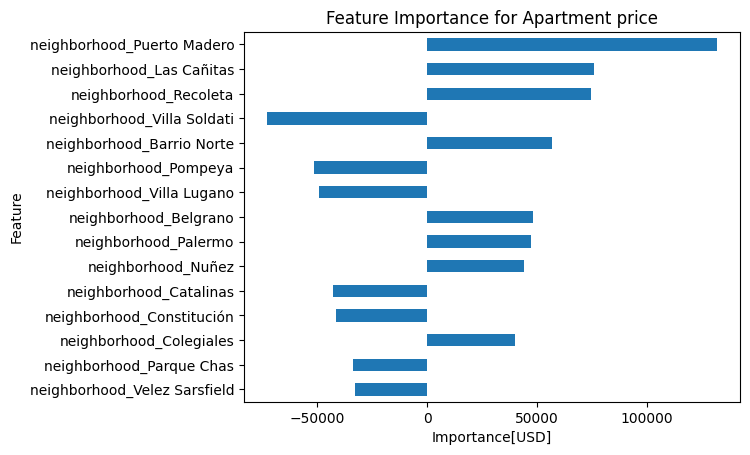

In [32]:
#Creating BarChart
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance[USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment price")

